<a href="https://www.kaggle.com/code/dalloliogm/autogluon-approach-to-fertiz?scriptVersionId=243037304" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Autogluon approach

Autogluon is an autoML tool from Amazon. It performed well in previous playground competitions. Let's try it out.

In [1]:
# Go to Add-ons > Install Dependencies to install this into the environment
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 15.4 MB/s eta 0:0

## Parameters

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from autogluon.tabular import TabularPredictor
import polars as pl
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [3]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    "autogluon_time": 60*60*0.2,
    "autogluon_presets": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_presets"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 720.0, 'autogluon_presets': 'best_quality', 'tail_rows': 0}


## Read data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s5e6/sample_submission.csv')


In [5]:
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [6]:
from autogluon.tabular import TabularPredictor


## Some Feature Engineering

In [7]:
# 🧹 Step 2: Custom Feature Engineering Transformer
class FertilizerFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_ = list(X.columns) + [
            'N_P_ratio', 'N_K_ratio', 'P_K_ratio',
            'Temp_Humidity', 'Soil_Crop'
        ]
        return self

    def transform(self, X):
        X = X.copy()
        X['N_P_ratio'] = X['Nitrogen'] / (X['Phosphorous'] + 1)
        X['N_K_ratio'] = X['Nitrogen'] / (X['Potassium'] + 1)
        X['P_K_ratio'] = X['Phosphorous'] / (X['Potassium'] + 1)
        X['Temp_Humidity'] = X['Temparature'] * X['Humidity']
        X['Soil_Crop'] = X['Soil Type'] + '_' + X['Crop Type']
        return X[self.feature_names_]

In [8]:
# 🏗️ Step 4: Build sklearn-style pipeline
feature_engineering = ColumnTransformer(transformers=[
    ('fertilizer_features', FertilizerFeatureEngineer(),  train.drop(columns='Fertilizer Name').columns),
])

pipeline = Pipeline(steps=[
    ('feature_eng', feature_engineering)
])


In [9]:
# Use it directly in pipeline
pipeline = Pipeline([
    ('fertilizer_features', FertilizerFeatureEngineer())
])

# Fit and transform
X_train = pipeline.fit_transform(train.drop(columns='Fertilizer Name'))
X_train['Fertilizer Name'] = train['Fertilizer Name']

# Same for test
X_test = pipeline.transform(test)
X_train

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,N_P_ratio,N_K_ratio,P_K_ratio,Temp_Humidity,Soil_Crop,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,6.000000,7.200000,1.000000,2590,Clayey_Sugarcane,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,1.578947,4.285714,2.571429,1863,Sandy_Millets,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,1.411765,1.846154,1.230769,1827,Sandy_Millets,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,7.800000,3.000000,0.307692,2170,Sandy_Barley,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,2.176471,12.333333,5.333333,2030,Red_Paddy,DAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,1.142857,0.470588,0.352941,1725,Clayey_Maize,28-28
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,1.809524,4.222222,2.222222,2368,Loamy_Sugarcane,17-17-17
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,0.200000,0.500000,2.416667,2380,Sandy_Ground Nuts,10-26-26
749998,749998,31,68,29,Red,Cotton,9,11,12,0.692308,0.750000,1.000000,2108,Red_Cotton,20-20


In [10]:
X_test

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,N_P_ratio,N_K_ratio,P_K_ratio,Temp_Humidity,Soil_Crop
0,750000,31,70,52,Sandy,Wheat,34,11,24,1.360000,2.833333,2.000000,2170,Sandy_Wheat
1,750001,27,62,45,Red,Sugarcane,30,14,15,1.875000,2.000000,1.000000,1674,Red_Sugarcane
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4,2.800000,0.875000,0.250000,2016,Clayey_Ground Nuts
3,750003,37,53,57,Black,Ground Nuts,18,17,36,0.486486,1.000000,2.000000,1961,Black_Ground Nuts
4,750004,31,55,32,Red,Pulses,13,19,14,0.866667,0.650000,0.700000,1705,Red_Pulses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,26,66,30,Red,Sugarcane,14,7,18,0.736842,1.750000,2.250000,1716,Red_Sugarcane
249996,999996,33,62,55,Red,Pulses,28,14,7,3.500000,1.866667,0.466667,2046,Red_Pulses
249997,999997,36,53,64,Black,Paddy,28,11,27,1.000000,2.333333,2.250000,1908,Black_Paddy
249998,999998,36,67,26,Clayey,Paddy,33,0,10,3.000000,33.000000,10.000000,2412,Clayey_Paddy


## Train Predictor

Autogluon will try several models and parameters. To trigger the training, just call .fit().

In [11]:
label = 'Fertilizer Name'
predictor = TabularPredictor(label="Fertilizer Name", 
                            eval_metric="log_loss").\
                fit(
                            X_train,
                            presets=config["autogluon_presets"],
                            time_limit=config["autogluon_time"])


No path specified. Models will be saved in: "AutogluonModels/ag-20250601_095023"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.90 GB / 31.35 GB (95.4%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [12]:
# 🔮 Step 7: Predict top 3 fertilizers
probs = predictor.predict_proba(X_test)

top3 = probs.apply(lambda row: ' '.join(row.nlargest(3).index), axis=1)

In [13]:
# from sklearn.metrics import label_ranking_average_precision_score
# import numpy as np

# # Ground truth as binary indicator matrix
# y_true = pd.get_dummies(test['Fertilizer Name']).values
# y_score = probs[test.columns[1:]]  # drop 'id'

# map3 = label_ranking_average_precision_score(y_true, y_score)
# print(f'MAP@3: {map3:.4f}')


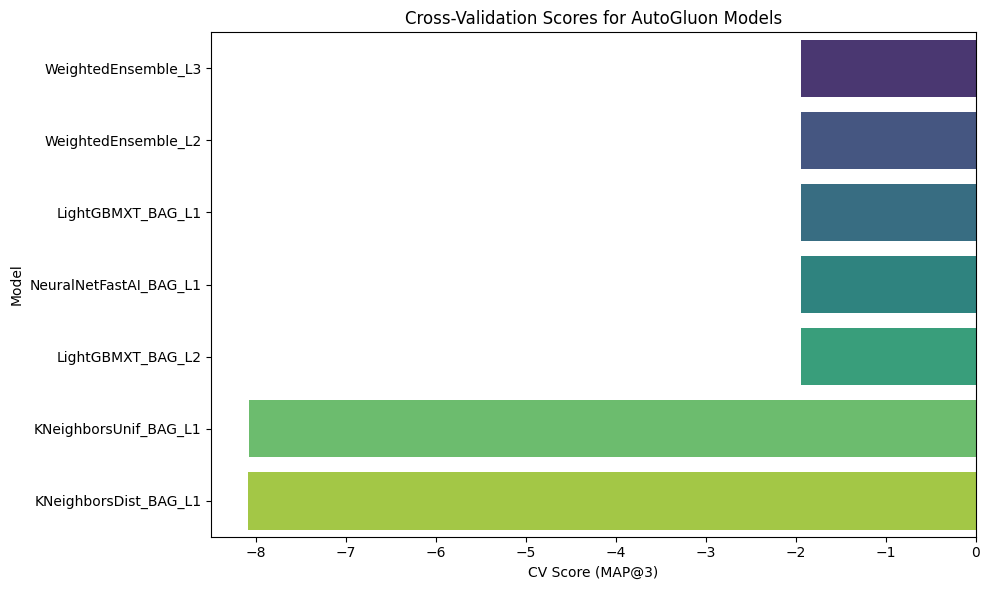

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get leaderboard with scores
lb = predictor.leaderboard(silent=True)

# Filter only models with valid CV scores
lb = lb[~lb['score_val'].isna()]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=lb, x='score_val', y='model', palette='viridis')
plt.xlabel('CV Score (MAP@3)')
plt.ylabel('Model')
plt.title('Cross-Validation Scores for AutoGluon Models')
plt.tight_layout()
plt.show()


## Map 3 evaluation on validation split

In [15]:
# from sklearn.model_selection import train_test_split

# # Train/val split
# train_part, val_part = train_test_split(train, test_size=0.2, stratify=train['Fertilizer Name'], random_state=42)
# X_train = pipeline.fit_transform(train_part.drop(columns='Fertilizer Name'))
# X_train['Fertilizer Name'] = train_part['Fertilizer Name']
# X_val = pipeline.transform(val_part)

# # Retrain
# predictor = TabularPredictor(label='Fertilizer Name', eval_metric='log_loss').fit(X_train,
#                                                                                 presets=config["autogluon_presets"],
#                                                                                 time_limit=config["autogluon_time"])
# probs_val = predictor.predict_proba(X_val)
# top3_val = probs_val.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

# # MAP@3 metric
# def mapk(y_true, y_pred, k=3):
#     def apk(actual, predicted, k):
#         predicted = predicted[:k]
#         score = 0.0
#         for i, p in enumerate(predicted):
#             if p == actual:
#                 score = 1.0 / (i + 1)
#                 break
#         return score
#     return np.mean([apk(a, p, k) for a, p in zip(y_true, y_pred)])

# y_true = val_part['Fertilizer Name'].values
# print(f'MAP@3: {mapk(y_true, top3_val):.4f}')


In [16]:
# 📤 Step 8: Prepare submission
submission = pd.DataFrame({'id': test['id'], 'Fertilizer Name': top3})
submission.to_csv('submission.csv', index=False)